In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings as wg
import textwrap

from sklearn.cluster import KMeans
from matplotlib.ticker import FuncFormatter
from scipy.stats import binom
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import silhouette_score

wg.filterwarnings('ignore')

In [19]:
def millions_formatter(x, pos):
    return f'{x / 1e6} M'

def thousands_formatter(x, pos):
    return f'{x / 1e3} K'

def standard_decimal_notation_formatter(x):
    return '{:.2f}'.format(x)

In [20]:
population_df = pd.read_csv('population_df_1996.csv')
migration_df = pd.read_csv('migration_df_1996.csv')

In [21]:
# Filter the migration dataset
migration_filtered = migration_df[
    (migration_df['Country'] == 'All countries') &
    (migration_df['Sex'] != 'Both sexes') &
    (migration_df['Origin or Destination'] == 'Net migration')
]

# Simplify the population dataset to include only the total population count for each year and sex
population_filtered = population_df[
    (population_df['Sex'] != 'Both sexes') &
    (population_df['Single Year of Age'] == 'All ages')
][['Year', 'Sex', 'VALUE']]

# Now, let's merge the datasets on 'Year' and 'Sex'
merged_data = pd.merge(
    population_filtered,
    migration_filtered,
    on=['Year', 'Sex'],
    how='inner'
)

# Since we only want 'Net migration' figures, we can drop columns related to 'Country' and 'Origin or Destination'
merged_data = merged_data.drop(columns=['Country', 'Origin or Destination'])

# Finally, let's filter the merged data to include only the years from 1996 to 2023
merged_data_filtered = merged_data[
    (merged_data['Year'] >= 1996) & (merged_data['Year'] <= 2023)
]

# Check for any missing years and missing values after filtering
years_in_merged_data = merged_data_filtered['Year'].unique()
missing_years_merged = set(range(1996, 2024)) - set(years_in_merged_data)
missing_values_merged = merged_data_filtered.isnull().sum()

(years_in_merged_data, missing_years_merged, missing_values_merged)


(array([1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006,
        2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
        2018, 2019, 2020, 2021, 2022, 2023], dtype=int64),
 set(),
 Year                0
 Sex                 0
 VALUE_x             0
 Country category    0
 Sex category        0
 Migration label     0
 UNIT                0
 VALUE_y             0
 dtype: int64)

In [22]:
merged_data_filtered

,Year,Sex,VALUE_x,Country category,Sex category,Migration label,UNIT,VALUE_y
0,1996,Male,1800232,-,1,1,Thousand,3.5
1,1996,Female,1825855,-,2,1,Thousand,4.4
2,1997,Male,1819394,-,1,1,Thousand,9.5
3,1997,Female,1844919,-,2,1,Thousand,9.7
4,1998,Male,1838859,-,1,1,Thousand,8.8
5,1998,Female,1864223,-,2,1,Thousand,8.6
6,1999,Male,1858613,-,1,1,Thousand,9.0
7,1999,Female,1883034,-,2,1,Thousand,8.3
8,2000,Male,1882946,-,1,1,Thousand,13.1
9,2000,Female,1906590,-,2,1,Thousand,12.9


In [23]:
# Drop the unnecessary columns
merged_data_cleaned = merged_data_filtered.drop(columns=['Country category', 'Sex category', 'Migration label', 'UNIT'])

# Convert migration figures from 'thousands' to absolute numbers by multiplying by 1000
merged_data_cleaned['Net Migration'] = merged_data_cleaned['VALUE_y'] * 1000

# Calculate net migration rate per 1,000 individuals
merged_data_cleaned['Net Migration Rate'] = merged_data_cleaned['Net Migration'] / merged_data_cleaned['VALUE_x'] * 1000

# Display the cleaned and updated dataframe
merged_data_cleaned


,Year,Sex,VALUE_x,VALUE_y,Net Migration,Net Migration Rate
0,1996,Male,1800232,3.5,3500.0,1.944194
1,1996,Female,1825855,4.4,4400.0,2.409830
2,1997,Male,1819394,9.5,9500.0,5.221519
3,1997,Female,1844919,9.7,9700.0,5.257683
4,1998,Male,1838859,8.8,8800.0,4.785576
5,1998,Female,1864223,8.6,8600.0,4.613182
6,1999,Male,1858613,9.0,9000.0,4.842321
7,1999,Female,1883034,8.3,8300.0,4.407780
8,2000,Male,1882946,13.1,13100.0,6.957183
9,2000,Female,1906590,12.9,12900.0,6.766006


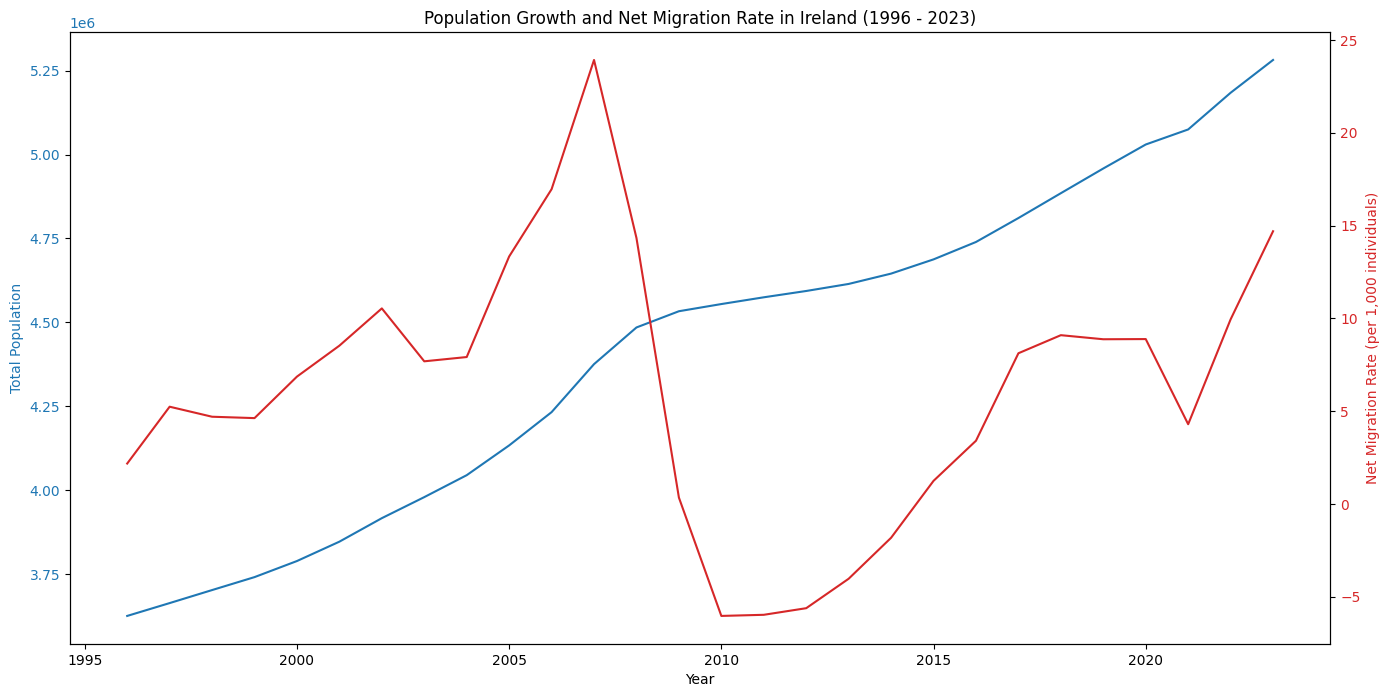

In [24]:
# Group the data by year to see the overall trend, summing net migration and averaging the rate
annual_data = merged_data_cleaned.groupby('Year').agg({'VALUE_x':'sum', 'Net Migration':'sum', 'Net Migration Rate':'mean'}).reset_index()

# Plot population growth and net migration rate trends
fig, ax1 = plt.subplots(figsize=(14, 7))

color = 'tab:blue'
ax1.set_xlabel('Year')
ax1.set_ylabel('Total Population', color=color)
ax1.plot(annual_data['Year'], annual_data['VALUE_x'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.set_ylabel('Net Migration Rate (per 1,000 individuals)', color=color)
ax2.plot(annual_data['Year'], annual_data['Net Migration Rate'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # to ensure the right y-label is not slightly clipped
plt.title('Population Growth and Net Migration Rate in Ireland (1996 - 2023)')
plt.show()


The visualization shows the total population and the net migration rate in Ireland from 1996 to 2023.

From the blue line representing the total population, you can see the population trend over time. The red line shows the net migration rate, which can fluctuate significantly from year to year, indicating periods of higher or lower net migration.

### **Clustering an unsupervised learning technique**

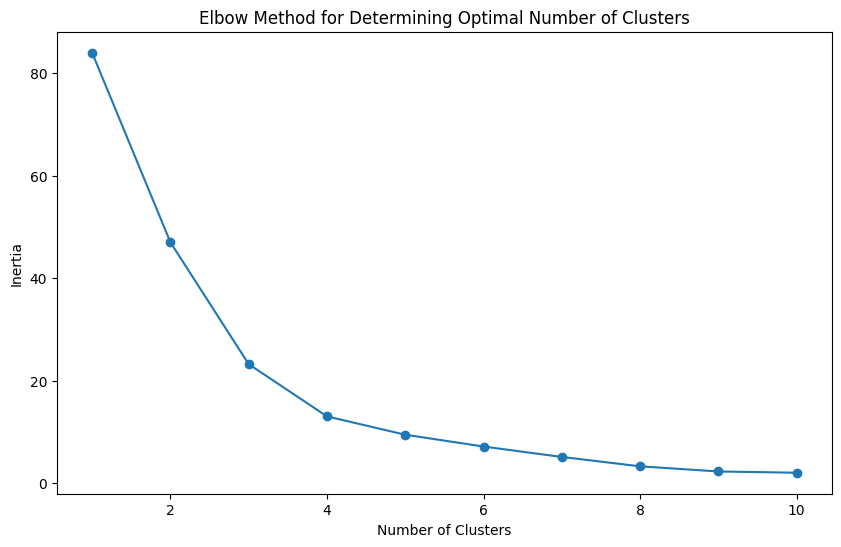

In [25]:
# Standardize the features before clustering
scaler = StandardScaler()
annual_data_scaled = scaler.fit_transform(annual_data[['VALUE_x', 'Net Migration', 'Net Migration Rate']])

# Use the elbow method to find the optimal number of clusters
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(annual_data_scaled)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Determining Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

Now, we'll perform K-means clustering with this range of cluster numbers to explore the data segmentation. Let's start with 3 clusters and then we can try 4 clusters to compare. We'll then analyze the characteristics of each cluster to see if they correspond to any meaningful patterns or periods.​

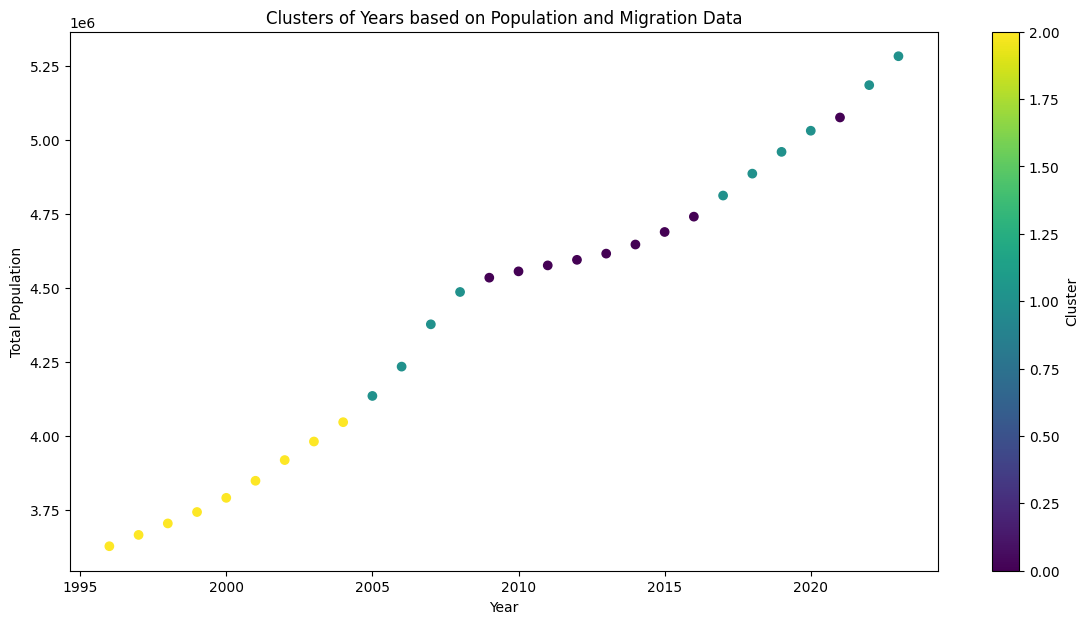

,Year,VALUE_x,Net Migration,Net Migration Rate
Cluster,,,,
0,2013.444444,4.668767e+06,-6888.888889,-1.577020
1,2014.500000,4.737740e+06,59750.000000,12.816799
2,2000.000000,3.812679e+06,24944.444444,6.474505


In [26]:
# Perform K-means clustering with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=0)
clusters = kmeans.fit_predict(annual_data_scaled)

# Add the cluster information to the original annual data for interpretation
annual_data['Cluster'] = clusters

# Visualize the clusters
plt.figure(figsize=(14, 7))
plt.scatter(annual_data['Year'], annual_data['VALUE_x'], c=annual_data['Cluster'], cmap='viridis', marker='o')
plt.title('Clusters of Years based on Population and Migration Data')
plt.xlabel('Year')
plt.ylabel('Total Population')
plt.colorbar(label='Cluster')
plt.show()

# Let's see the average values for each cluster to understand their characteristics
cluster_characteristics = annual_data.groupby('Cluster').mean()
cluster_characteristics


* Cluster 0 (Mean Year: 2013.44, Mean Population: ~4.67 million, Mean Net Migration: -6,889, Mean Net Migration Rate: -1.58 per 1,000 individuals): This cluster represents years with negative net migration (emigration) and a slightly smaller population, which might correspond to economic downturns or other events causing more people to leave than enter the country.
  
* Cluster 1 (Mean Year: 2014.5, Mean Population: ~4.74 million, Mean Net Migration: +59,750, Mean Net Migration Rate: +12.82 per 1,000 individuals): This cluster seems to represent years with high positive net migration and a larger population, suggesting periods of high immigration.

* Cluster 2 (Mean Year: 2000, Mean Population: ~3.81 million, Mean Net Migration: +24,944, Mean Net Migration Rate: +6.47 per 1,000 individuals): This cluster includes years with positive net migration, though less than Cluster 0, and a significantly smaller population size. These could be years of beginning growth or recovery.

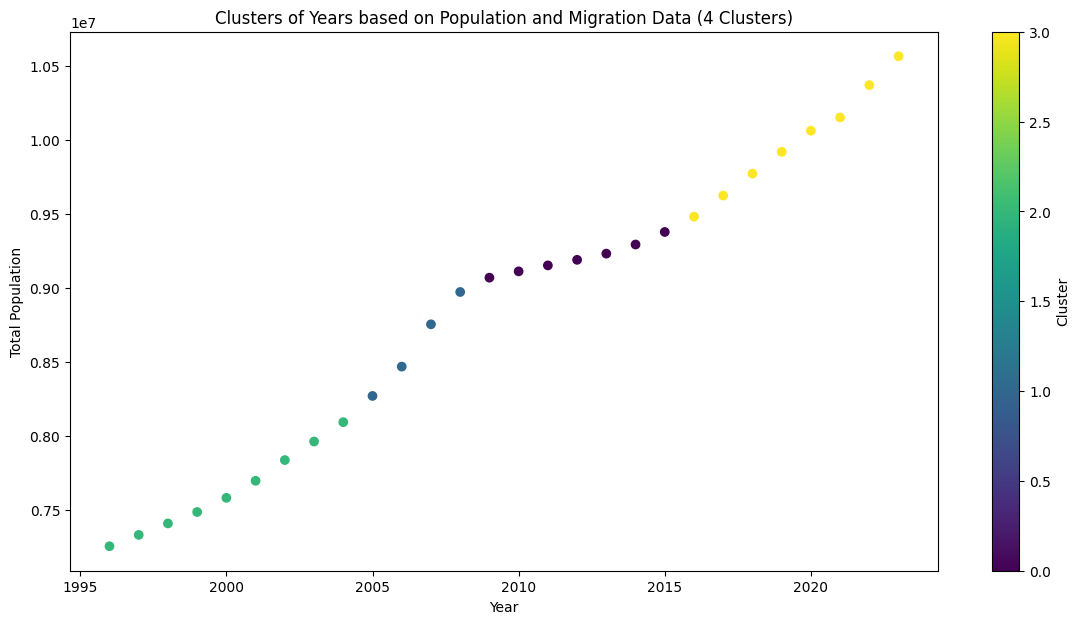

,Year,VALUE_x,Net Migration,Net Migration Rate
Cluster_4,,,,
0,2012.0,9.201325e+06,-1.441414e+06,-3288.107726
1,2006.5,8.613840e+06,7.471475e+06,17734.499763
2,2000.0,7.625357e+06,2.519389e+06,9040.680714
3,2019.5,9.990995e+06,4.286188e+06,4610.987982


In [28]:
# Data preprocessing based on previous steps
# Filter the migration dataset for 'All countries' and 'Net migration'
migration_filtered = migration_df[(migration_df['Country'] == 'All countries') & 
                                  (migration_df['Origin or Destination'] == 'Net migration')]

# Filter out 'Both sexes' from the 'Sex' column
migration_filtered = migration_filtered[migration_filtered['Sex'] != 'Both sexes']

# Merge datasets on 'Year' and 'Sex'
merged_data = pd.merge(population_df, migration_filtered, how='inner', on=['Year', 'Sex'])

# Clean and prepare the data
merged_data['Net Migration'] = merged_data['VALUE_y'] * 1000  # Convert to absolute numbers
merged_data['Net Migration Rate'] = merged_data['Net Migration'] / merged_data['VALUE_x'] * 1000
annual_data = merged_data.groupby('Year').agg({'VALUE_x':'sum', 'Net Migration':'sum', 'Net Migration Rate':'mean'}).reset_index()

# Standardize the features
scaler = StandardScaler()
annual_data_scaled = scaler.fit_transform(annual_data[['VALUE_x', 'Net Migration', 'Net Migration Rate']])

# Perform K-means clustering with 4 clusters
kmeans_4 = KMeans(n_clusters=4, random_state=0)
clusters_4 = kmeans_4.fit_predict(annual_data_scaled)

# Add the cluster information to the original annual data for interpretation
annual_data['Cluster_4'] = clusters_4

# Visualize the clusters
plt.figure(figsize=(14, 7))
plt.scatter(annual_data['Year'], annual_data['VALUE_x'], c=annual_data['Cluster_4'], cmap='viridis', marker='o')
plt.title('Clusters of Years based on Population and Migration Data (4 Clusters)')
plt.xlabel('Year')
plt.ylabel('Total Population')
plt.colorbar(label='Cluster')
plt.show()

# Calculate the average values for each cluster
cluster_characteristics_4 = annual_data.groupby('Cluster_4').mean()
cluster_characteristics_4


* Cluster 0: Represents the early 2010s with a significant population but negative net migration, likely reflecting the aftermath of the economic recession when emigration surpassed immigration.
  
* Cluster 1: Represents the mid-2000s with a high population and extremely high net migration, likely corresponding to the peak of the Celtic Tiger economic boom when Ireland experienced significant immigration.

* Cluster 2: Represents the year 2000, which seems to be an outlier year with lower total population and net migration rates than the boom years, potentially marking the beginning of significant economic and population growth.

* Cluster 3: Represents the late 2010s with the highest population figures and moderate net migration rates, possibly indicative of a stabilized population growth with ongoing but less intense migration compared to the boom years.